#### This script tries to use tf.dataset API. 
It seems lots of things aren't quite documented correctly yet and standard dataset functions don't exist: like .labels

In [16]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training

BATCH_SIZE = 256

mixed_precision.set_global_policy('mixed_float16')


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("EmbryoLabeling/Labelers/train")


In [29]:
train=tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    image_size = (299,299),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical',
    shuffle = True
)

# 20% split between test/train here.
test_batches = tf.data.experimental.cardinality(train)
train_dataset = train.skip(test_batches // 5)
test_dataset = train.take(test_batches // 5)

print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print(test_dataset)

#training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=True)

# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
#validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)

Found 13626 files belonging to 14 classes.
Number of train batches: 44
Number of test batches: 10
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None))>


In [32]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299,299,3),
    include_top=False)  # Do not include the ImageNet classifier at the top.


# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1./127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
#x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(14, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 14)                28686     
                                                                 
Total params: 20,890,166
Trainable params: 28,686
Non-trainable params: 20,861,480
__________________________________________

In [33]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)


(256, 14)


In [34]:
%%time
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)


CPU times: user 13 ms, sys: 238 µs, total: 13.2 ms
Wall time: 12.1 ms


In [35]:
model.fit(train_dataset,
            epochs=5,
            validation_data=test_dataset)

Epoch 1/5
44/44 [==============================] - 17s 327ms/step - loss: 1.5509 - categorical_accuracy: 0.5459 - val_loss: 1.0579 - val_categorical_accuracy: 0.6973
Epoch 2/5
44/44 [==============================] - 14s 311ms/step - loss: 0.9551 - categorical_accuracy: 0.7318 - val_loss: 0.8201 - val_categorical_accuracy: 0.7457
Epoch 3/5
44/44 [==============================] - 14s 310ms/step - loss: 0.7913 - categorical_accuracy: 0.7708 - val_loss: 0.7063 - val_categorical_accuracy: 0.7785
Epoch 4/5
44/44 [==============================] - 14s 312ms/step - loss: 0.6975 - categorical_accuracy: 0.7945 - val_loss: 0.6327 - val_categorical_accuracy: 0.8016
Epoch 5/5
44/44 [==============================] - 14s 309ms/step - loss: 0.6321 - categorical_accuracy: 0.8151 - val_loss: 0.5796 - val_categorical_accuracy: 0.8215


In [36]:



history = model.fit(train_dataset,
                    epochs=500,
                    verbose=0, # TQDMProgressBar logs out the info, so no need for the default logs
                    validation_data=test_dataset,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=10, verbose=0),
                        tfa.callbacks.TQDMProgressBar()
                    ])

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/44           ETA: ?s - 

Epoch 2/500


0/44           ETA: ?s - 

Epoch 3/500


0/44           ETA: ?s - 

Epoch 4/500


0/44           ETA: ?s - 

Epoch 5/500


0/44           ETA: ?s - 

Epoch 6/500


0/44           ETA: ?s - 

Epoch 7/500


0/44           ETA: ?s - 

Epoch 8/500


0/44           ETA: ?s - 

Epoch 9/500


0/44           ETA: ?s - 

Epoch 10/500


0/44           ETA: ?s - 

Epoch 11/500


0/44           ETA: ?s - 

Epoch 12/500


0/44           ETA: ?s - 

Epoch 13/500


0/44           ETA: ?s - 

Epoch 14/500


0/44           ETA: ?s - 

Epoch 15/500


0/44           ETA: ?s - 

Epoch 16/500


0/44           ETA: ?s - 

Epoch 17/500


0/44           ETA: ?s - 

Epoch 18/500


0/44           ETA: ?s - 

Epoch 19/500


0/44           ETA: ?s - 

Epoch 20/500


0/44           ETA: ?s - 

Epoch 21/500


0/44           ETA: ?s - 

Epoch 22/500


0/44           ETA: ?s - 

Epoch 23/500


0/44           ETA: ?s - 

Epoch 24/500


0/44           ETA: ?s - 

Epoch 25/500


0/44           ETA: ?s - 

Epoch 26/500


0/44           ETA: ?s - 

Epoch 27/500


0/44           ETA: ?s - 

Epoch 28/500


0/44           ETA: ?s - 

Epoch 29/500


0/44           ETA: ?s - 

Epoch 30/500


0/44           ETA: ?s - 

Epoch 31/500


0/44           ETA: ?s - 

Epoch 32/500


0/44           ETA: ?s - 

Epoch 33/500


0/44           ETA: ?s - 

Epoch 34/500


0/44           ETA: ?s - 

Epoch 35/500


0/44           ETA: ?s - 

Epoch 36/500


0/44           ETA: ?s - 

Epoch 37/500


0/44           ETA: ?s - 

Epoch 38/500


0/44           ETA: ?s - 

Epoch 39/500


0/44           ETA: ?s - 

Epoch 40/500


0/44           ETA: ?s - 

Epoch 41/500


0/44           ETA: ?s - 

Epoch 42/500


0/44           ETA: ?s - 

Epoch 43/500


0/44           ETA: ?s - 

Epoch 44/500


0/44           ETA: ?s - 

Epoch 45/500


0/44           ETA: ?s - 

Epoch 46/500


0/44           ETA: ?s - 

Epoch 47/500


0/44           ETA: ?s - 

Epoch 48/500


0/44           ETA: ?s - 

Epoch 49/500


0/44           ETA: ?s - 

Epoch 50/500


0/44           ETA: ?s - 

Epoch 51/500


0/44           ETA: ?s - 

Epoch 52/500


0/44           ETA: ?s - 

Epoch 53/500


0/44           ETA: ?s - 

Epoch 54/500


0/44           ETA: ?s - 

Epoch 55/500


0/44           ETA: ?s - 

Epoch 56/500


0/44           ETA: ?s - 

Epoch 57/500


0/44           ETA: ?s - 

Epoch 58/500


0/44           ETA: ?s - 

Epoch 59/500


0/44           ETA: ?s - 

Epoch 60/500


0/44           ETA: ?s - 

Epoch 61/500


0/44           ETA: ?s - 

Epoch 62/500


0/44           ETA: ?s - 

Epoch 63/500


0/44           ETA: ?s - 

Epoch 64/500


0/44           ETA: ?s - 

Epoch 65/500


0/44           ETA: ?s - 

Epoch 66/500


0/44           ETA: ?s - 

Epoch 67/500


0/44           ETA: ?s - 

Epoch 68/500


0/44           ETA: ?s - 

Epoch 69/500


0/44           ETA: ?s - 

Epoch 70/500


0/44           ETA: ?s - 

Epoch 71/500


0/44           ETA: ?s - 

Epoch 72/500


0/44           ETA: ?s - 

Epoch 73/500


0/44           ETA: ?s - 

Epoch 74/500


0/44           ETA: ?s - 

Epoch 75/500


0/44           ETA: ?s - 

Epoch 76/500


0/44           ETA: ?s - 

Epoch 77/500


0/44           ETA: ?s - 

Epoch 78/500


0/44           ETA: ?s - 

Epoch 79/500


0/44           ETA: ?s - 

Epoch 80/500


0/44           ETA: ?s - 

Epoch 81/500


0/44           ETA: ?s - 

Epoch 82/500


0/44           ETA: ?s - 

Epoch 83/500


0/44           ETA: ?s - 

Epoch 84/500


0/44           ETA: ?s - 

Epoch 85/500


0/44           ETA: ?s - 

Epoch 86/500


0/44           ETA: ?s - 

Epoch 87/500


0/44           ETA: ?s - 

Epoch 88/500


0/44           ETA: ?s - 

Epoch 89/500


0/44           ETA: ?s - 

Epoch 90/500


0/44           ETA: ?s - 

Epoch 91/500


0/44           ETA: ?s - 

Epoch 92/500


0/44           ETA: ?s - 

Epoch 93/500


0/44           ETA: ?s - 

Epoch 94/500


0/44           ETA: ?s - 

Epoch 95/500


0/44           ETA: ?s - 

Epoch 96/500


0/44           ETA: ?s - 

Epoch 97/500


0/44           ETA: ?s - 

Epoch 98/500


0/44           ETA: ?s - 

Epoch 99/500


0/44           ETA: ?s - 

<AxesSubplot:>

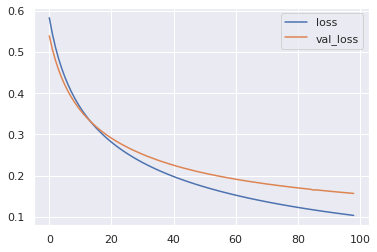

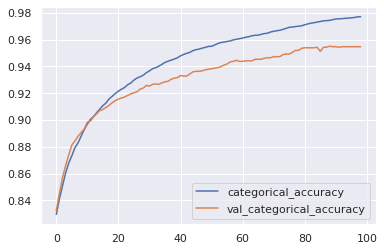

In [37]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [42]:
#print("True:", test_dataset.labels)
print("Predictions: ", model.predict(test_dataset).argmax(axis=1))

10/10 [==============================] - 3s 251ms/step
Predictions:  [10  3 10 ... 12 10  4]


In [43]:
y_pred = model.predict(test_dataset)

10/10 [==============================] - 2s 249ms/step


In [44]:
predicted_codes = y_pred.argmax(axis=1)
confidence = pd.Series(y_pred.max(axis=1))
confidence.describe()

count    2560.000000
mean        0.917969
std         0.144897
min         0.255859
25%         0.906616
50%         0.994629
75%         1.000000
max         1.000000
dtype: float64

In [ ]:
validation_df["predicted_class"] = [code2class[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

In [ ]:
validation_df.groupby("class").confidence.median()

In [ ]:
validation_df.to_csv("validation_predictions.csv", index=False)

In [ ]:
print(classification_report(validation_df["class"], validation_df["predicted_class"]))
labels = list(training.class_indices.keys())
s = sns.heatmap(
    confusion_matrix(validation_df["class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=labels,
    yticklabels=labels
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [ ]:
model.save(f"models/dense_{len(code2class)}_class.h5")

In [ ]:
# Make some predictions on unlabelled data
folders = os.listdir("EmbryoLabeling/Labelers/One")
folders = [f for f in folders if re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"EmbryoLabeling/Labelers/One/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = "unknown"
    files.append(files_in_folder)
test_df = pd.concat(files)
test_df

In [ ]:
class TQDMPredictCallback(keras.callbacks.Callback):
    def __init__(self, custom_tqdm_instance=None, tqdm_cls=tqdm, **tqdm_params):
        super().__init__()
        self.tqdm_cls = tqdm_cls
        self.tqdm_progress = None
        self.prev_predict_batch = None
        self.custom_tqdm_instance = custom_tqdm_instance
        self.tqdm_params = tqdm_params

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        self.tqdm_progress.update(batch - self.prev_predict_batch)
        self.prev_predict_batch = batch

    def on_predict_begin(self, logs=None):
        self.prev_predict_batch = 0
        if self.custom_tqdm_instance:
            self.tqdm_progress = self.custom_tqdm_instance
            return

        total = self.params.get('steps')
        if total:
            total -= 1

        self.tqdm_progress = self.tqdm_cls(total=total, **self.tqdm_params)

    def on_predict_end(self, logs=None):
        if self.tqdm_progress and not self.custom_tqdm_instance:
            self.tqdm_progress.close()

test = datagen.flow_from_dataframe(test_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)
results = model.predict(test, callbacks=[TQDMPredictCallback()])

In [ ]:
predicted_codes = results.argmax(axis=1)
confidence = pd.Series(results.max(axis=1))
confidence.describe()

In [ ]:
test_df["class"] = [code2class[c] for c in predicted_codes]
test_df["confidence"] = confidence

In [ ]:
test_df["class"].value_counts()

In [ ]:
test_df

In [ ]:
test_df.to_csv("predictions.csv", index=False)

In [ ]:
pwd()